This is a notebook to plot the aspect ratios of all pseduo_labels and its corresponding ground truths. 

In [3]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [123]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
from prototype_utils import (
    filter_gt_labels_by_category,
    extract_face_corners,
    filter_cuboids_by_roi,
    filter_roi,
    bboxes_df_to_numpy_corners)
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from av2.structures.cuboid import  CuboidList
from config import CONFIG

In [ ]:
home = os.path.join(os.path.expanduser('~'), "buni")

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 1
frame_idx = 0

scene_id = av2.get_log_ids()[scene_idx]
print(f"scene_id: {scene_id}")
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
print(f"frame_id: {frame_id}")
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)
print(f"frame_path: {frame_path}")

points = Sweep.from_feather(frame_path).xyz

scene_id: ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd
frame_id: 315968335160099000
frame_path: C:\Users\Ravi\buni\dataset\av2\train\ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd\sensors\lidar\315968335160099000.feather


In [127]:
if CONFIG['ROI']:
    ps_path = os.path.join(home, *CONFIG['FILTERED_BBOX_FILE_PATHS']['ROI'])
else:
    ps_path = os.path.join(home, *CONFIG['FILTERED_BBOX_FILE_PATHS']['FULL_RANGE'])


The chosen scene in pseudo_labels and the one in dataset should have the same id

In [128]:
print(os.listdir(ps_path)[scene_idx])
print(scene_id)

ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd
ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd


In [129]:
ps_scene_path = os.path.join(ps_path, os.listdir(ps_path)[scene_idx])

The frame at index 0 in pseudo_labels and the one in dataset should be the same, i.e., have same timestamp

In [130]:
print(os.listdir(ps_scene_path)[frame_idx])
print(frame_id)

315968335160099000.feather
315968335160099000


In [131]:
ps_scene_path

'C:\\Users\\Ravi\\buni\\output-data\\av2\\filtered_bboxes\\roi\\ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd'

In [132]:
ps_frame_path = os.path.join(ps_scene_path, os.listdir(ps_scene_path)[frame_idx])

ps_labels_df = pd.read_feather(ps_frame_path)

In [133]:
def get_pseudo_label_corners_scene(ps_scene_path: str) -> np.ndarray:
    """
    Processes all the pseudo-label files in the given scene path and returns a 
    combined numpy array of shape (P, 4, 2), where P is the total number of bounding boxes.

    Args:
        ps_scene_path (str): Path to the scene folder containing pseudo-label files.

    Returns:
        np.ndarray: A numpy array of shape (P, 4, 2) representing all bounding box corners.
    """
    main_lst = []

    for iddx, frame in enumerate(os.listdir(ps_scene_path)):
        ps_frame_path = os.path.join(ps_scene_path, frame)
        ps_labels_df = pd.read_feather(ps_frame_path)

        # Convert the DataFrame to numpy array of shape (Q, 4, 2)
        corners_array = bboxes_df_to_numpy_corners(ps_labels_df)
        main_lst.append(corners_array)

    # Combine all arrays into one of shape (P, 4, 2)
    combined_array = np.vstack(main_lst)
    return combined_array

ps_scene_corners = get_pseudo_label_corners_scene(ps_scene_path)

In [134]:
def get_pseudo_label_corners_all(ps_base_path: str):
    main_lst = []
    
    for scene in os.listdir(ps_base_path):
        ps_scene_path = os.path.join(ps_base_path, scene)
        scene_corners = get_pseudo_label_corners_scene(ps_scene_path)
        main_lst.append(scene_corners)
    
    return np.vstack(main_lst)

ps_corners_all = get_pseudo_label_corners_all(ps_path)

In [135]:
ps_corners = bboxes_df_to_numpy_corners(ps_labels_df)

In [136]:
ps_corners.shape

(18, 4, 2)

We have loaded dataframe of pseudo_labels. Now, we load the gt_labels

In [137]:
def get_all_cuboids_for_a_scene(av2: AV2SensorDataLoader, scene_id: str, config: dict):
    frame_ids = av2.get_ordered_log_lidar_timestamps(scene_id)
    # print(f"Number of frames: {len(frame_ids)}")
    main_lst = []
    for idx, frame_id in  enumerate(frame_ids):
        cuboids = av2.get_labels_at_lidar_timestamp(scene_id, frame_id)
        relevant_cuboids = filter_gt_labels_by_category(cuboids, config)
        # print(relevant_cuboids.cuboids[0])
        main_lst.extend(relevant_cuboids.cuboids)
        # gt_corners = extract_face_corners(relevant_cuboids.vertices_m)
        # gt_corners_roi = filter_cuboids_by_roi(gt_corners, config)

    return CuboidList(main_lst)

all_cuboids_scene = get_all_cuboids_for_a_scene(av2, scene_id, CONFIG)

In [138]:
def get_all_cuboids(av2: AV2SensorDataLoader, config: dict):
    scene_ids = av2.get_log_ids()
    main_lst = []
    for scene_id in scene_ids:
        main_lst.extend(get_all_cuboids_for_a_scene(av2, scene_id, config).cuboids)
    return CuboidList(main_lst)
    

all_cuboids = get_all_cuboids(av2, CONFIG)

In [139]:
# av2_cuboids = av2.get_labels_at_lidar_timestamp(scene_id, frame_id)

In [140]:
relevant_cuboids = filter_gt_labels_by_category(all_cuboids, CONFIG)

In [141]:
gt_corners = extract_face_corners(relevant_cuboids.vertices_m)


gt_corners_roi = filter_cuboids_by_roi(gt_corners, CONFIG)

We have the gt_labels for the correct categories in the ROI. Now we simply visualize both of them 

In [142]:
points = Sweep.from_feather(av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)).xyz
points_roi = filter_roi(points)

In [143]:
# from prototype_utils import plot_point_cloud_and_bboxes

# plot_point_cloud_and_bboxes(points_roi[:,:2], ps_corners)
# plot_point_cloud_and_bboxes(points_roi[:,:2], gt_corners_roi)

If I am to plot aspect ratios of bounding boxes, then I am not limited to ROI, because the aspect ratio of of a gt_lable of a car is the same, whether it is in ROI or not. 


In [144]:

def calc_aspect_ratio_and_area(gt_corners: np.ndarray):
    lst_of_dicts = []
    for cuboid in gt_corners:
        side_1 = np.linalg.norm(cuboid[0] - cuboid[1])
        side_2 = np.linalg.norm(cuboid[1] - cuboid[2])
        side_3 = np.linalg.norm(cuboid[2] - cuboid[3])
        side_4 = np.linalg.norm(cuboid[3] - cuboid[0])
        
        length = max(side_1, side_2, side_3, side_4)
        width = min(side_1, side_2, side_3, side_4)
        aspect_ratio = width / length
        area = length * width
        lst_of_dicts.append({"corners": cuboid,"aspect_ratio": aspect_ratio, "area": area})

    return lst_of_dicts
        
gt_corners_calculated = calc_aspect_ratio_and_area(gt_corners)

In [145]:
areas = [cuboid["area"] for cuboid in gt_corners_calculated]
aspect_ratios = [cuboid["aspect_ratio"] for cuboid in gt_corners_calculated]

In [146]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def plot_kde(aspect_ratios, title="Aspect Ratios of GT Cuboids (KDE)"):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean and standard deviation on the plot.
    
    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)
    
    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel("Aspect Ratio")
    plt.ylabel("Density")
    plt.title(title)
    
    # Add mean and std deviation as text on the plot
    text_str = f"Mean: {mean_value:.4f}\nStd Dev: {std_dev:.4f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

# Example usage:
# aspect_ratios = [cuboid["aspect_ratio"] for cuboid in gt_corners_calculated]
# plot_kde(aspect_ratios)
# plot_kde(areas, title="Areas of GT Cuboids (KDE)")


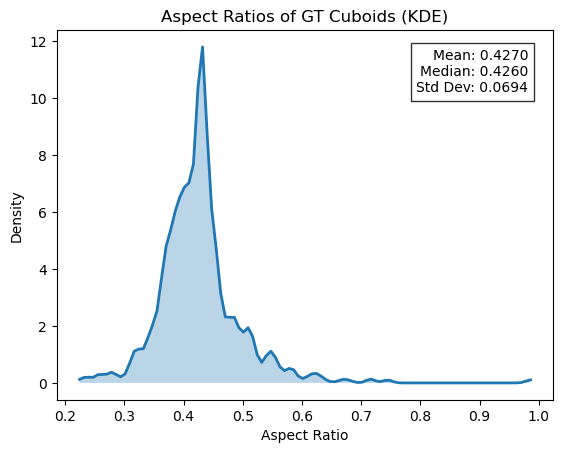

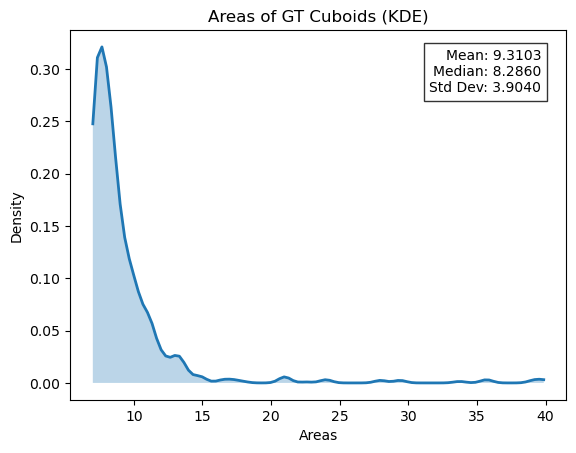

In [155]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def plot_kde2(aspect_ratios,x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids (KDE)"):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.
    
    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)
    
    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

# Example usage:
# aspect_ratios = [cuboid["aspect_ratio"] for cuboid in gt_corners_calculated]
plot_kde2(aspect_ratios)
plot_kde2(areas, x_label="Areas",title="Areas of GT Cuboids (KDE)")


In [156]:
ps_corners_calculated = calc_aspect_ratio_and_area(ps_corners_all)

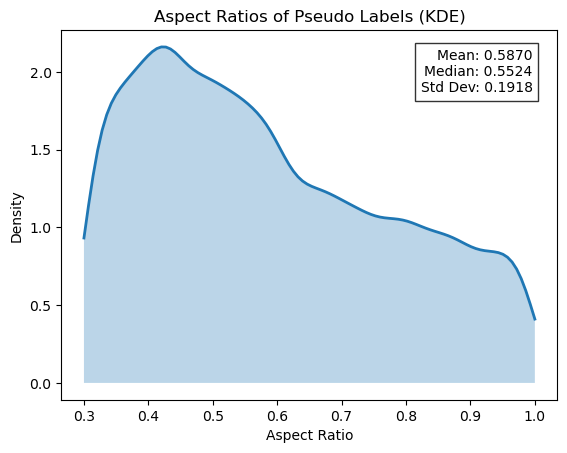

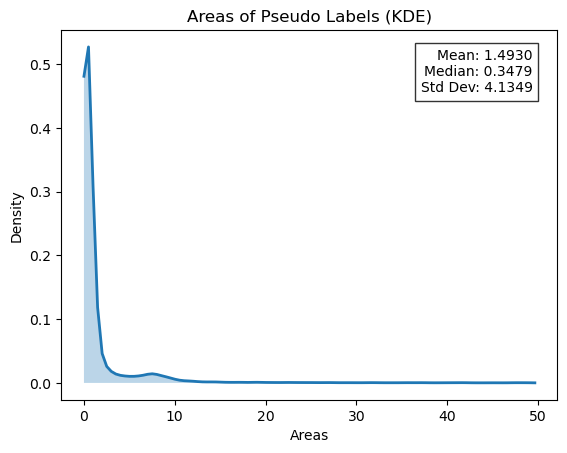

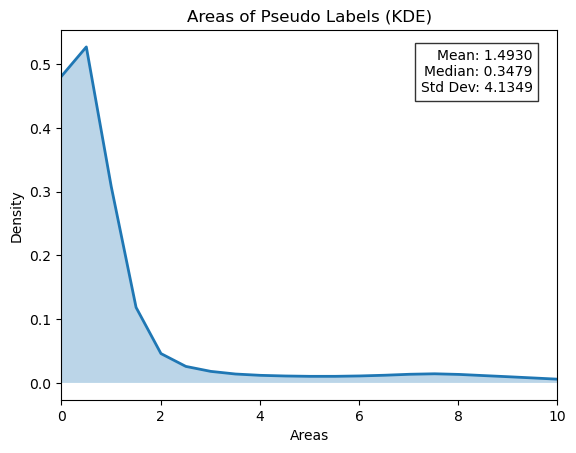

In [158]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def plot_kde3(aspect_ratios, x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids (KDE)", xlim=(0, 10)):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.

    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)

    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)

    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Set x-axis limit to focus on the range 0-5
    plt.xlim(xlim)

    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()


ps_aspect_ratios = [cuboid["aspect_ratio"] for cuboid in ps_corners_calculated]
ps_areas = [cuboid["area"] for cuboid in ps_corners_calculated]

plot_kde2(ps_aspect_ratios, title="Aspect Ratios of Pseudo Labels (KDE)")
plot_kde2(ps_areas,x_label="Areas", title="Areas of Pseudo Labels (KDE)")
plot_kde3(ps_areas,x_label="Areas", title="Areas of Pseudo Labels (KDE)")